In [3]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
IMAGE_SIZE= 256
BATCH_SIZE= 32
CHANNELS=3
EPOCHS=100

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:

class_names = dataset.class_names
print("Class names:", class_names)




Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [7]:
len(dataset)

68

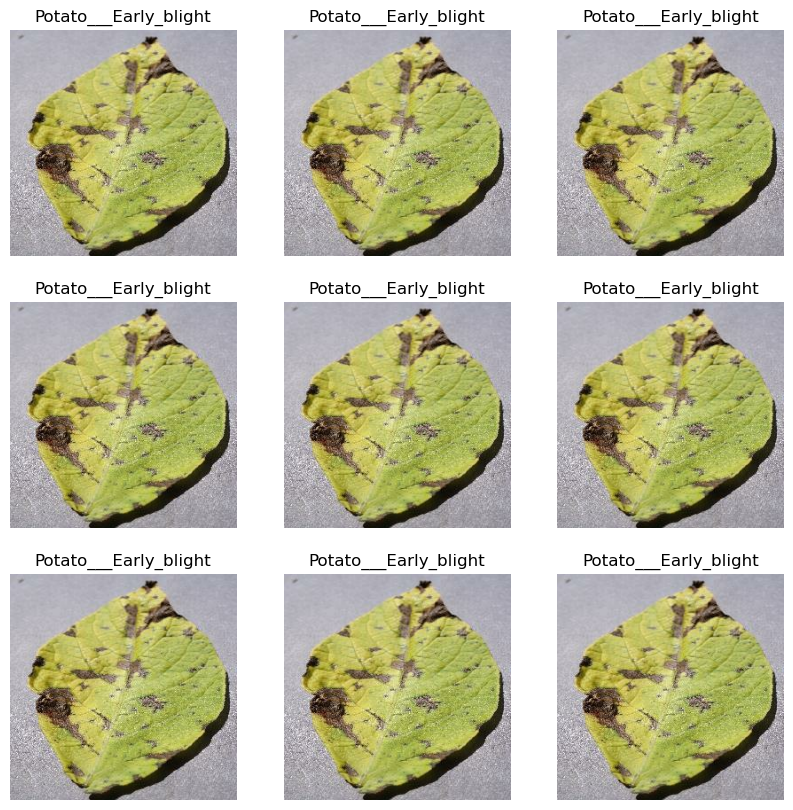

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


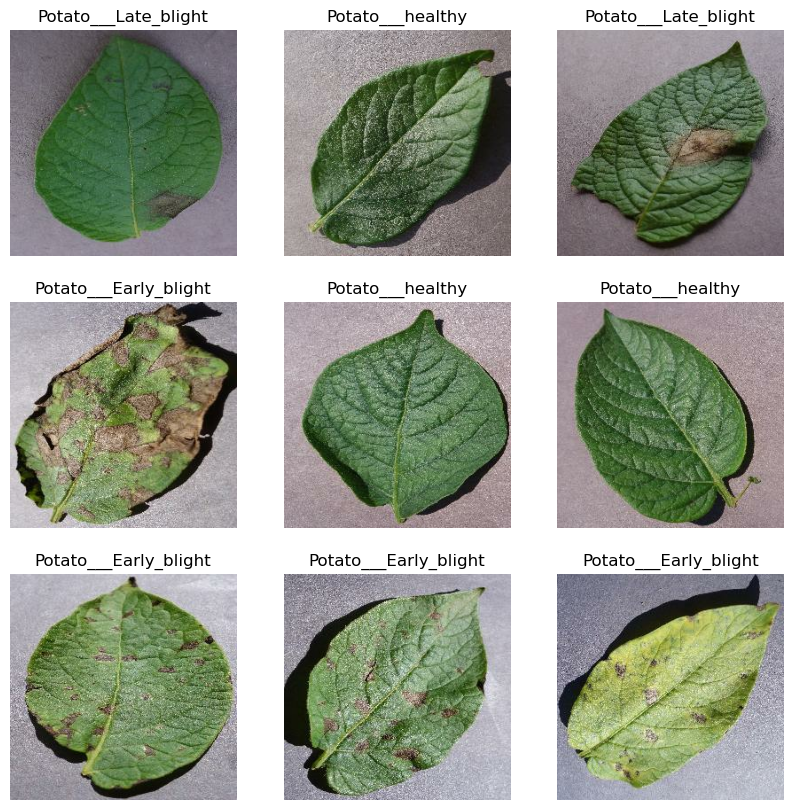

In [9]:
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    
    plt.figure(figsize=(10, 10))
    for i in range(min(9, BATCH_SIZE)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
def get_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset(dataset)

In [18]:
K=len(train_ds)
M=len(val_ds)
J=len(test_ds)
print(K)
print(M)
print(J)

54
6
8


In [19]:

train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)  
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE) 




In [20]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])


In [21]:

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [23]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Lambda(lambda x: resize_and_rescale(x), input_shape=input_shape),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])



E:\ana\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,363 (56.61 MB)

 Trainable params: 14,839,363 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5363 - loss: 1.5394 - val_accuracy: 0.7865 - val_loss: 0.5119
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 950ms/step - accuracy: 0.8267 - loss: 0.4152 - val_accuracy: 0.9219 - val_loss: 0.2187
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 972ms/step - accuracy: 0.8860 - loss: 0.2663 - val_accuracy: 0.9167 - val_loss: 0.1895
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 971ms/step - accuracy: 0.9012 - loss: 0.2337 - val_accuracy: 0.9375 - val_loss: 0.1551
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 971ms/step - accuracy: 0.9577 - loss: 0.1298 - val_accuracy: 0.8958 - val_loss: 0.2598
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 972ms/step - accuracy: 0.9438 - loss: 0.1346 - val_accuracy: 0.8542 - val_loss: 0.4338
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 967ms/step - accuracy: 0.9391 - loss: 0.1519 - val_accuracy: 0.8177 - val_loss: 0.5233
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9577 - loss: 0.1147 - val_accuracy: 

In [56]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 475ms/step - accuracy: 0.9856 - loss: 0.0642


In [58]:

scores

[0.07794048637151718, 0.9765625]

In [62]:
print(history.history.keys())

acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


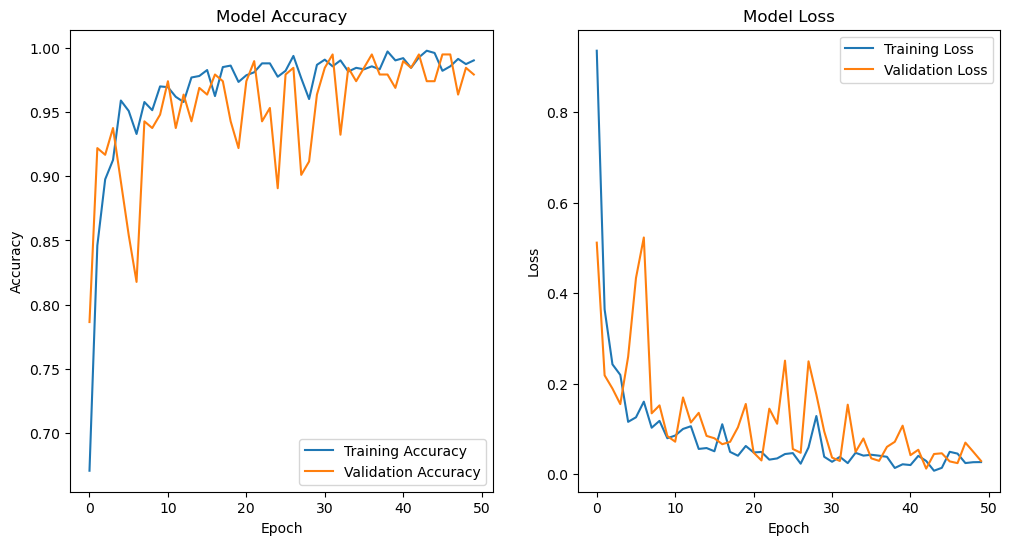

In [64]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
predicted label: Potato___Early_blight


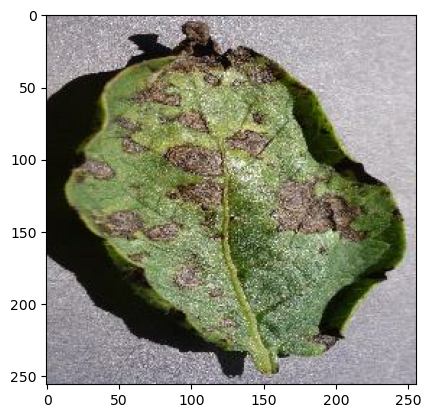

In [66]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [70]:
import numpy as np


def predict(model, img, class_names):

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


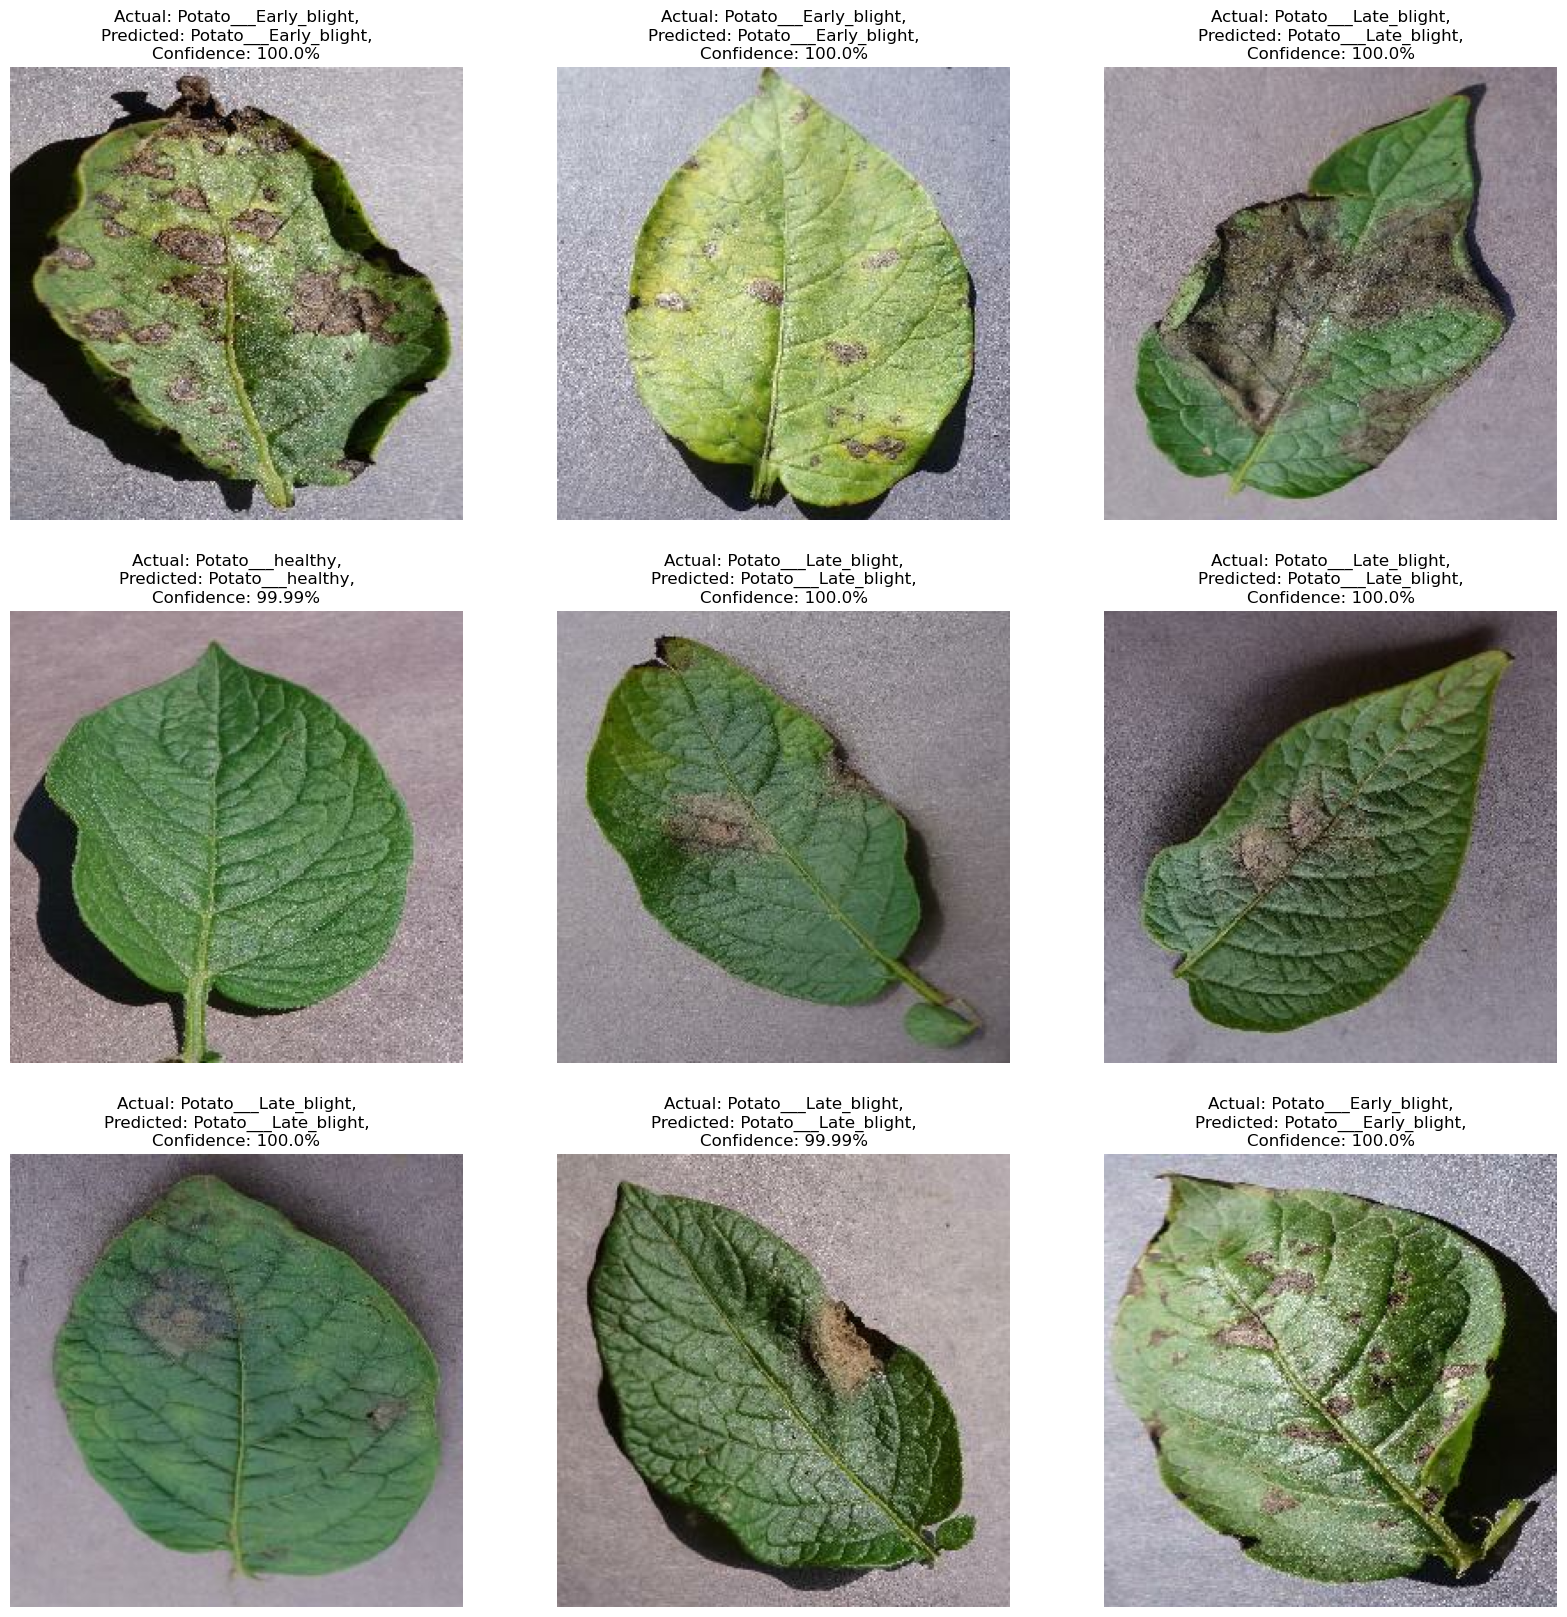

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i], class_names)
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")
        

        plt.axis("off")

plt.show()


In [82]:
import os


os.makedirs("../models", exist_ok=True)


model_version = max([int(i) for i in os.listdir("../models") if i.isdigit()] + [0]) + 1

model.save(f"../models/{model_version}.keras")
